In [54]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

aln.params.de = 0.
aln.params.di = 0.

aln.params.mue_ext_mean = 0.5 * 5.
aln.params.mui_ext_mean = 0.1 * 5.

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [25]:
dur = 5.
t_pen = 0.5

In [26]:
dur_pre = 0
dur_post = 0

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [0]
wp = 1. / (dur - t_pen * dur)

max_I = [3., -3.]
    
factor_ws = 1.
factor_we = 0.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

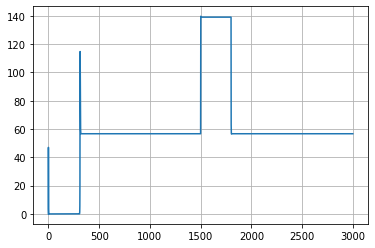

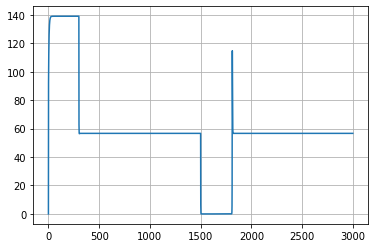

56.672169410985575 37.87626495494691


In [29]:
# get initial parameters and target states

aln.params.duration = 3000.

control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = max_I[0])

aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

control0 = functions.step_control(aln, maxI_ = max_I[1])
aln.run(control=control0)

plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

print(aln.rates_exc[0,-1], aln.rates_inh[0,-1])

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars

set cost params:  0.4 0.0 10.0
interpolate adjoint :  True True True
initial cost =  8.000000000000002
RUN  0 , total integrated cost =  8.000000000000002
Gradient descend method:  None
RUN  1 , total integrated cost =  5.904062182199085
RUN  2 , total integrated cost =  5.354010668095207
RUN  3 , total integrated cost =  5.1152229459419924
RUN  4 , total integrated cost =  4.993155384385124
RUN  5 , total integrated cost =  4.927844736088051
RUN  6 , total integrated cost =  4.888978131014763
RUN  7 , total integrated cost =  4.8661735108292685
RUN  8 , total integrated cost =  4.851568263485033
RUN  9 , total integrated cost =  4.842461612173984
RUN  10 , total integrated cost =  4.836540969291916
RUN  10 , total integrated cost =  4.836540969291916
Improved over  10  iterations in  0.12232585903257132  seconds by  39.543237883851056  percent.
(51,) (1, 6, 51)


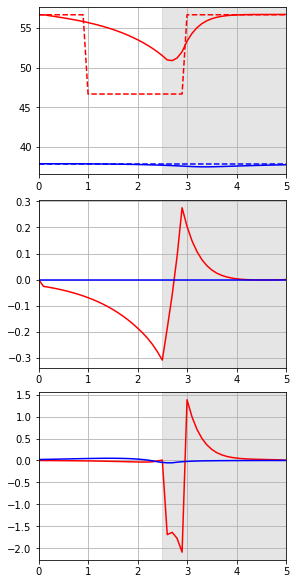

In [43]:
aln.params.duration = dur
setinit(initVars, aln)

target_ = aln.getZeroTarget()
target_[:,0,:] = initVars[0]
target_[:,1,:] = initVars[1]
target_[:,0,10:30] -= 10.

control0 = aln.getZeroControl()
cost.setParams(wp, 0., 10.)
max_it = int(10)

bestC_, bestS_, cost_, ru_, grad_, phi_, phi1_, costnode_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

if True:
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
    
    print(plot_time_array.shape, bestC_.shape)

    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
    ax[1].plot(plot_time_array, bestC_[0,0,:], color = 'red')
    ax[0].plot(plot_time_array, bestS_[0,0,:], color= 'red')
    ax[1].plot(plot_time_array, bestC_[0,1,:], color = 'blue')
    ax[0].plot(plot_time_array, bestS_[0,1,:], color= 'blue')
    ax[0].plot(plot_time_array, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(plot_time_array, target_[0,1,:], linestyle = '--', color='blue')


    ax[2].plot(plot_time_array, phi_[0,0,:], color = 'red')
    ax[2].plot(plot_time_array, phi_[0,1,:], color = 'blue')
    
    for k in range(3):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

set cost params:  0.4 0.0 10.0
interpolate adjoint :  True True True
initial cost =  13.11700151063213
RUN  0 , total integrated cost =  13.11700151063213
Gradient descend method:  None
RUN  0 , total integrated cost =  13.11700151063213
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


/tmp/ipykernel_950926/1023470560.py:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[2].set_yscale('log')


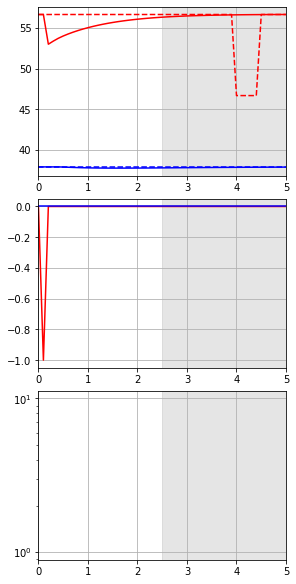

In [89]:
aln.params.duration = dur
setinit(initVars, aln)

target_ = aln.getZeroTarget()
target_[:,0,:] = initVars[0]
target_[:,1,:] = initVars[1]
target_[:,0,40:45] -= 10.

control0 = aln.getZeroControl()
control0[0,0,1] = -1.
cost.setParams(wp, 0., 10.)
max_it = int(0)

bestC_, bestS_, cost_, ru_, grad_, phi_, phi1_, costnode_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen, numerical=True)

if True:
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
    
    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
    ax[1].plot(plot_time_array, bestC_[0,0,:], color = 'red')
    ax[0].plot(plot_time_array, bestS_[0,0,:], color= 'red')
    ax[1].plot(plot_time_array, bestC_[0,1,:], color = 'blue')
    ax[0].plot(plot_time_array, bestS_[0,1,:], color= 'blue')
    ax[0].plot(plot_time_array, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(plot_time_array, target_[0,1,:], linestyle = '--', color='blue')


    ax[2].plot(plot_time_array[40:], phi_[0,0,40:], color = 'red')
    ax[2].plot(plot_time_array[40:], phi_[0,1,40:], color = 'blue')
    
    ax[2].set_yscale('log')
    
    for k in range(3):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()